In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_data = xr.load_dataset(
    "/home/strnad/data/climate_data/Europe/training/Germany/0.25/training_10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_surface_solar_radiation_downwards_6h.nc"
)
train_data
print(f"Size of data set in GB: {train_data.nbytes / 1e9:.2f} GB")

Size of data set in GB: 4.41 GB


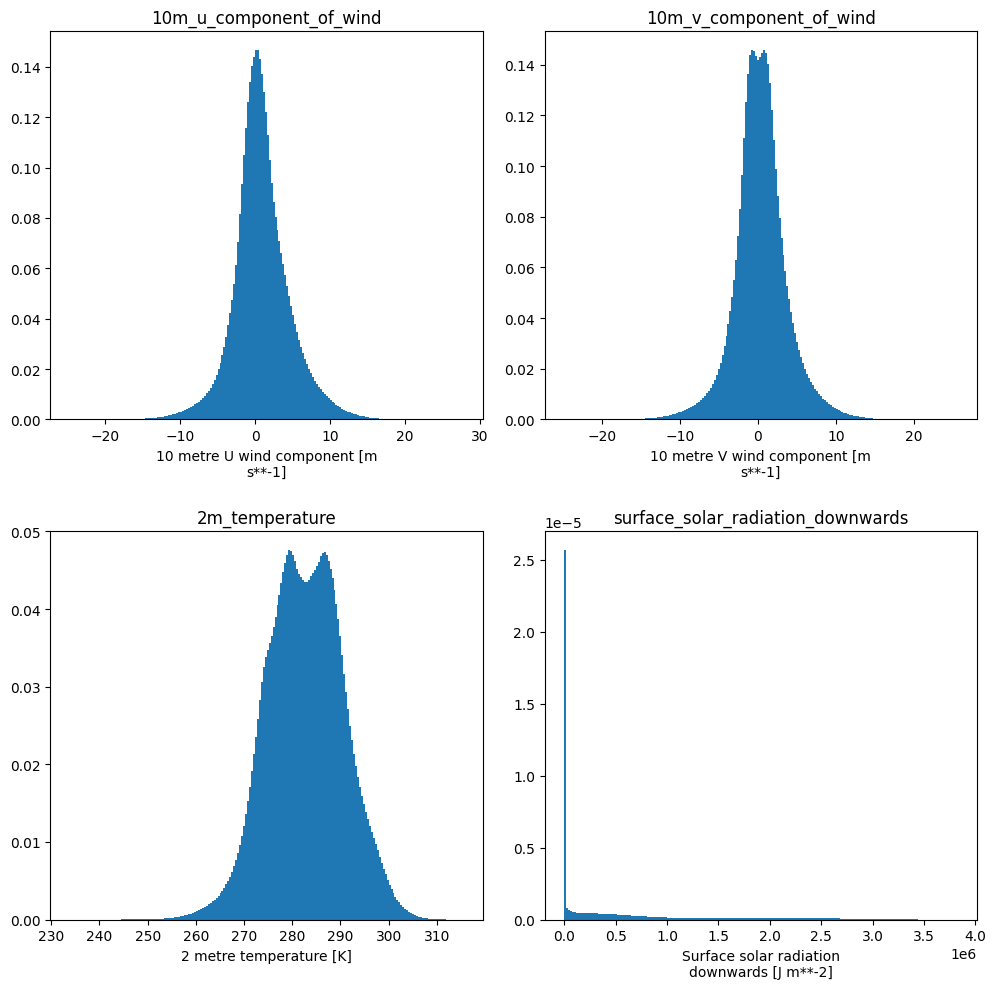

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for ax, dv in zip(axs, train_data.data_vars):
    data = train_data[dv]
    data.plot.hist(ax=ax, bins=200, density=True)
    ax.set_title(dv)
fig.tight_layout()

In [5]:
stats_folder = './'
min_ds = xr.load_dataset(f"{stats_folder}/0.25/stats/min.nc")
max_ds = xr.load_dataset(f"{stats_folder}/0.25/stats/max.nc")
mean_ds = xr.load_dataset(f"{stats_folder}/0.25/stats/mean.nc")
std_ds = xr.load_dataset(f"{stats_folder}/0.25/stats/std.nc")
min_ds

<xarray.Dataset> Size: 16B
Dimensions:                            ()
Data variables:
    10m_u_component_of_wind            float32 4B -24.69
    10m_v_component_of_wind            float32 4B -24.77
    2m_temperature                     float32 4B 233.9
    surface_solar_radiation_downwards  float32 4B 0.0

In [6]:
# quantiles = train_data.quantile([0.01, 0.025, 0.05, 0.95, 0.975, 0.99])
quantiles = xr.load_dataset(
    f"{stats_folder}/0.25/stats/quantiles.nc"
)
quantiles

<xarray.Dataset> Size: 144B
Dimensions:                            (quantile: 6)
Coordinates:
  * quantile                           (quantile) float64 48B 0.01 ... 0.99
Data variables:
    10m_u_component_of_wind            (quantile) float32 24B -8.978 ... 11.44
    10m_v_component_of_wind            (quantile) float32 24B -8.963 ... 9.754
    2m_temperature                     (quantile) float32 24B 263.9 ... 300.5
    surface_solar_radiation_downwards  (quantile) float32 24B 0.0 0.0 ... 6.477

In [7]:
# quantiles.to_netcdf(
#     "/mnt/data/climate/ERA/processed_025_2/0_25/stats/iqr/quantiles.nc",
#     encoding={var: {"dtype": "float32"} for var in train_data.data_vars},
# )

In [8]:
norm_shift = {
    "minmax": min_ds,
    "zscore": mean_ds,
    "quant99": quantiles.sel(quantile=0.01),
    "quant975": quantiles.sel(quantile=0.025),
    "quant95": quantiles.sel(quantile=0.05),
}
norm_scale = {
    "minmax": max_ds - min_ds,
    "zscore": std_ds,
    "quant99": quantiles.sel(quantile=0.99) - quantiles.sel(quantile=0.01),
    "quant975": quantiles.sel(quantile=0.975) - quantiles.sel(quantile=0.025),
    "quant95": quantiles.sel(quantile=0.95) - quantiles.sel(quantile=0.05),
}


def normalize(ds, mode):
    return (ds - norm_shift[mode]) / norm_scale[mode]

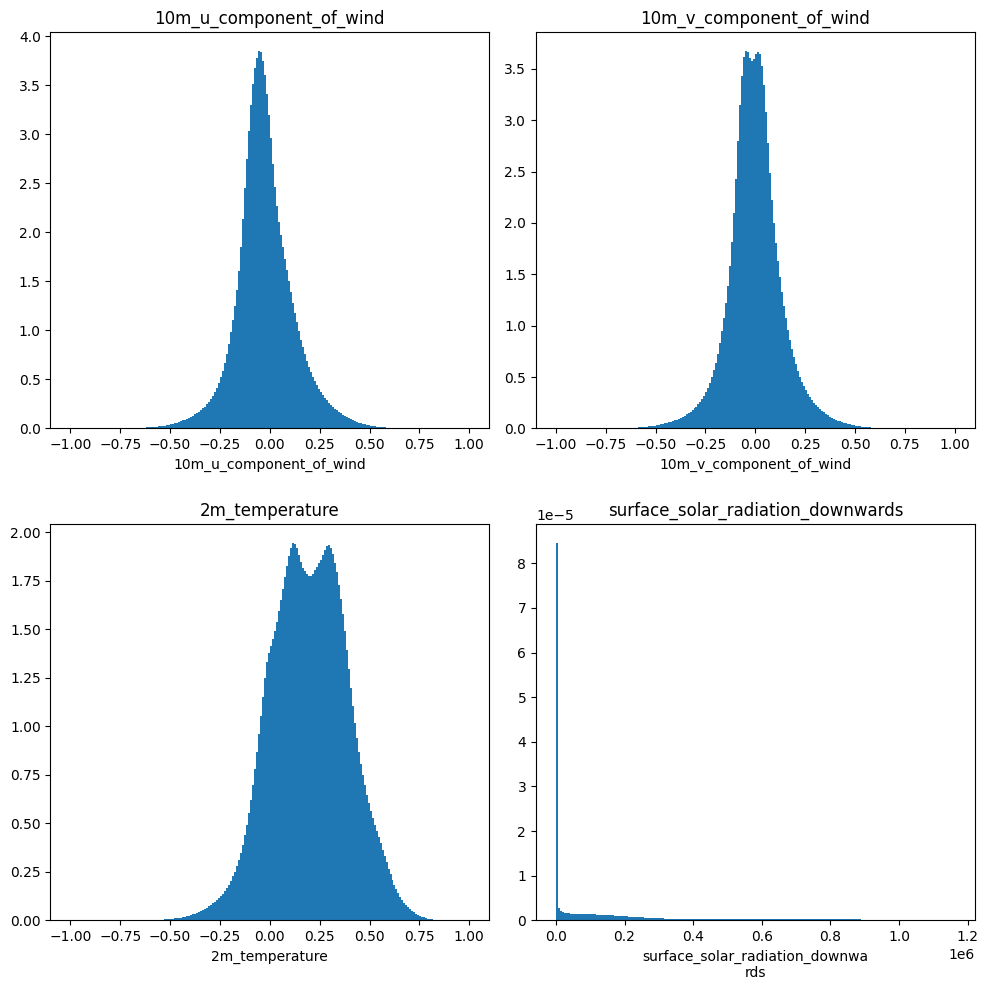

In [9]:
normed_ds = normalize(train_data, "minmax") * 2 - 1

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for ax, dv in zip(axs, train_data.data_vars):
    data = normed_ds[dv]
    data.plot.hist(ax=ax, bins=200, density=True)
    ax.set_title(dv)
fig.tight_layout()

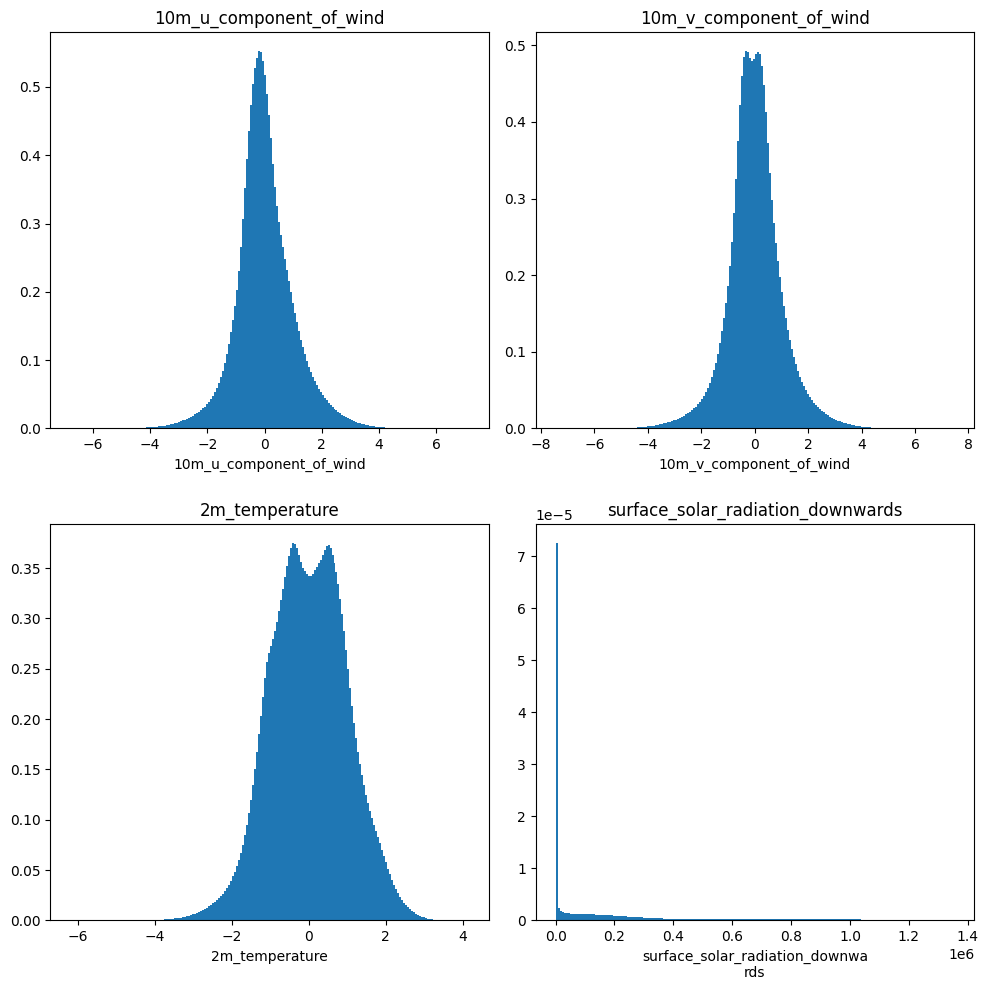

In [10]:
normed_ds = normalize(train_data, "zscore")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for ax, dv in zip(axs, train_data.data_vars):
    data = normed_ds[dv]
    data.plot.hist(ax=ax, bins=200, density=True)
    ax.set_title(dv)
fig.tight_layout()

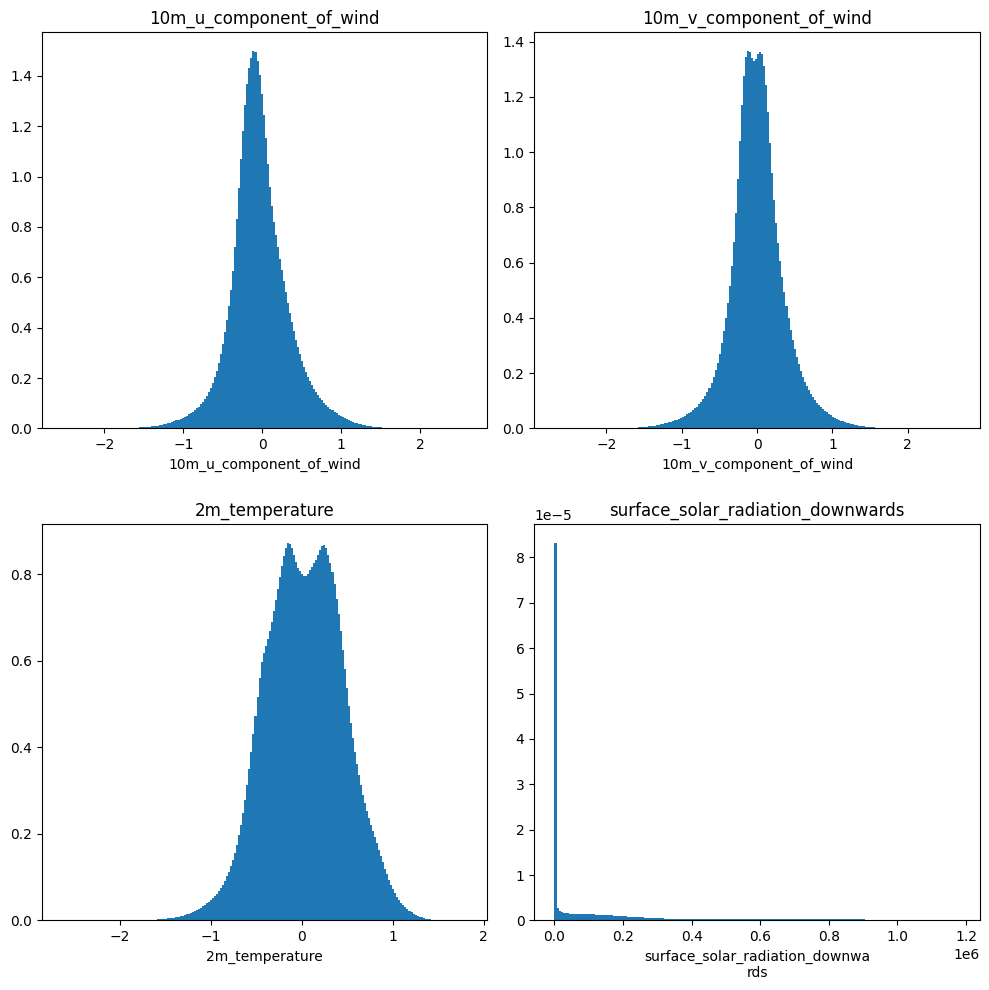

In [11]:
normed_ds = normalize(train_data, "quant99") * 2 - 1

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for ax, dv in zip(axs, train_data.data_vars):
    data = normed_ds[dv]
    data.plot.hist(ax=ax, bins=200, density=True)
    ax.set_title(dv)
fig.tight_layout()

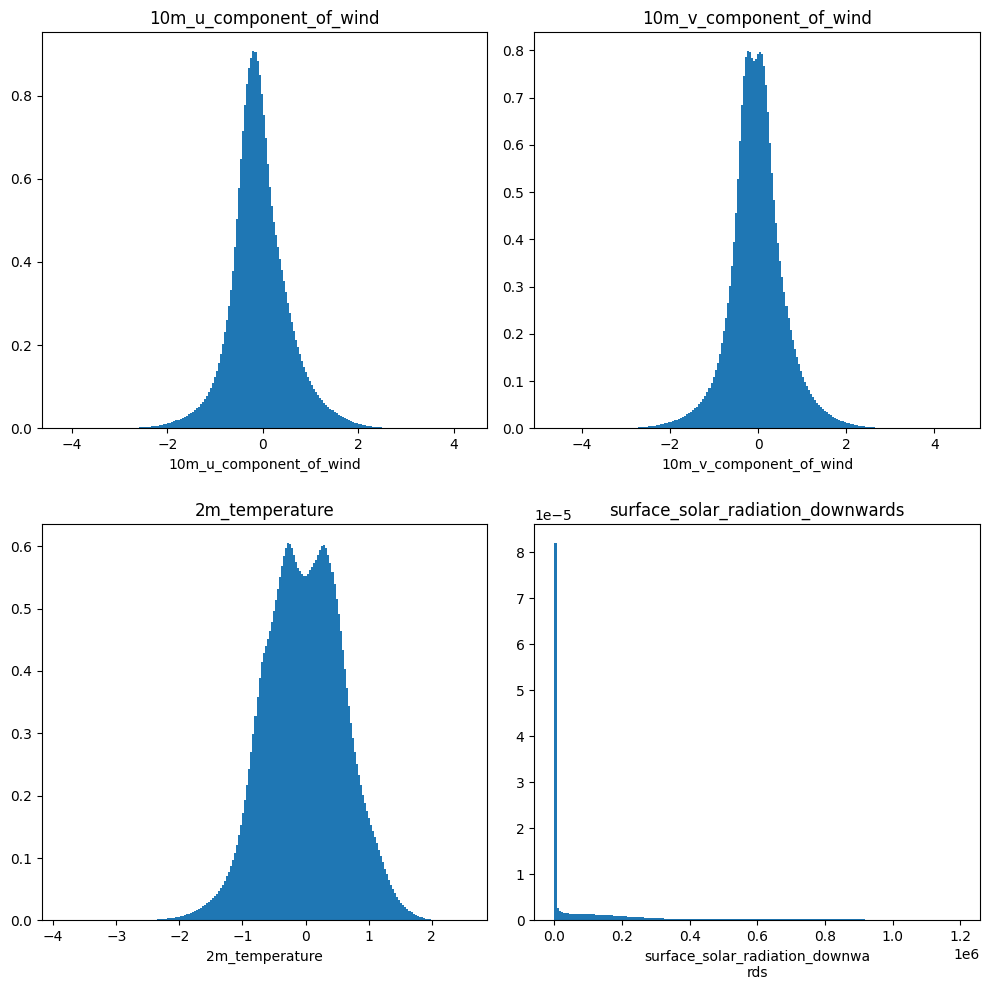

In [12]:
normed_ds = normalize(train_data, "quant95") * 2 - 1

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for ax, dv in zip(axs, train_data.data_vars):
    data = normed_ds[dv]
    data.plot.hist(ax=ax, bins=200, density=True)
    ax.set_title(dv)
fig.tight_layout()

<xarray.DataArray 'surface_solar_radiation_downwards' ()> Size: 8B
array(-1.)
Coordinates:
    quantile  float64 8B 0.01


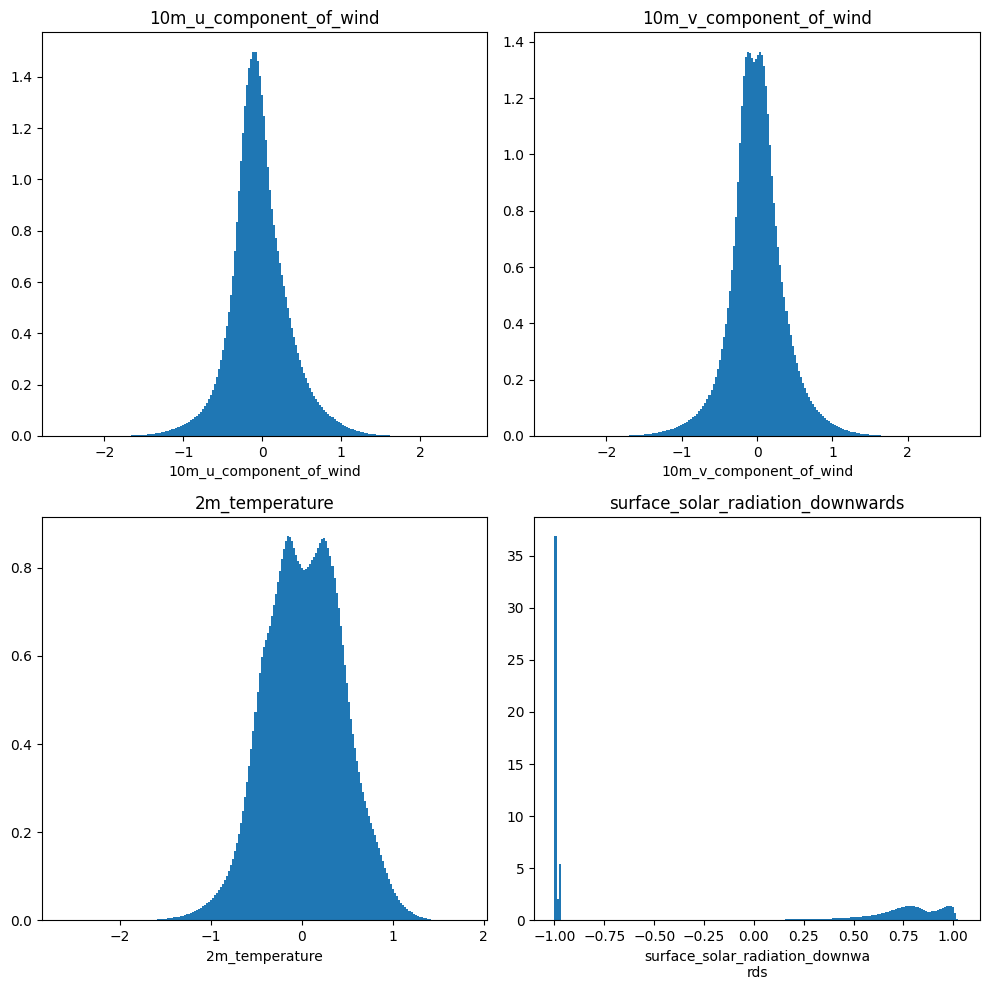

In [13]:
normed_ds = train_data.copy()

# TEMP
shift_temp = quantiles.sel(quantile=0.01)["2m_temperature"]
scale_temp = (
    quantiles.sel(quantile=0.99)["2m_temperature"]
    - quantiles.sel(quantile=0.01)["2m_temperature"]
)
normed_ds["2m_temperature"] = (normed_ds["2m_temperature"] - shift_temp) / scale_temp
normed_ds["2m_temperature"] = normed_ds["2m_temperature"] * 2 - 1

# WIND U
shift_wind_u = quantiles.sel(quantile=0.01)["10m_u_component_of_wind"]
scale_wind_u = (
    quantiles.sel(quantile=0.99)["10m_u_component_of_wind"]
    - quantiles.sel(quantile=0.01)["10m_u_component_of_wind"]
)
normed_ds["10m_u_component_of_wind"] = (
    normed_ds["10m_u_component_of_wind"] - shift_wind_u
) / scale_wind_u
normed_ds["10m_u_component_of_wind"] = normed_ds["10m_u_component_of_wind"] * 2 - 1


# WIND V
shift_wind_v = quantiles.sel(quantile=0.01)["10m_v_component_of_wind"]
scale_wind_v = (
    quantiles.sel(quantile=0.99)["10m_v_component_of_wind"]
    - quantiles.sel(quantile=0.01)["10m_v_component_of_wind"]
)
normed_ds["10m_v_component_of_wind"] = (
    normed_ds["10m_v_component_of_wind"] - shift_wind_v
) / scale_wind_v
normed_ds["10m_v_component_of_wind"] = normed_ds["10m_v_component_of_wind"] * 2 - 1

# SOLAR
normed_ds["surface_solar_radiation_downwards"] = normed_ds[
    "surface_solar_radiation_downwards"
].clip(min=0.0)
normed_ds["surface_solar_radiation_downwards"] = np.log10(
    normed_ds["surface_solar_radiation_downwards"] + 1
)
# shift_solar = normed_ds["surface_solar_radiation_downwards"].mean()
shift_solar = normed_ds["surface_solar_radiation_downwards"].quantile(0.01)
# scale_solar = normed_ds["surface_solar_radiation_downwards"].std()
scale_solar = normed_ds["surface_solar_radiation_downwards"].quantile(0.99) - normed_ds[
    "surface_solar_radiation_downwards"
].quantile(0.01)
normed_ds["surface_solar_radiation_downwards"] = (
    normed_ds["surface_solar_radiation_downwards"] - shift_solar
) / scale_solar
normed_ds["surface_solar_radiation_downwards"] = (
    normed_ds["surface_solar_radiation_downwards"] * 2 - 1
)

print(normed_ds["surface_solar_radiation_downwards"].min())

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for ax, dv in zip(axs, train_data.data_vars):
    data = normed_ds[dv]
    data.plot.hist(ax=ax, bins=200, density=True)
    ax.set_title(dv)
fig.tight_layout()

In [14]:
normed_ds

<xarray.Dataset> Size: 6GB
Dimensions:                            (lat: 64, time: 67209, lon: 64)
Coordinates:
  * lat                                (lat) float32 256B 43.0 43.25 ... 58.75
  * time                               (time) datetime64[ns] 538kB 1979-01-01...
  * lon                                (lon) float32 256B 3.0 3.25 ... 18.75
    quantile                           float64 8B 0.01
Data variables:
    10m_u_component_of_wind            (time, lat, lon) float32 1GB 0.4128 .....
    10m_v_component_of_wind            (time, lat, lon) float32 1GB -0.08681 ...
    2m_temperature                     (time, lat, lon) float32 1GB 0.1896 .....
    surface_solar_radiation_downwards  (time, lat, lon) float64 2GB -1.0 ... ...

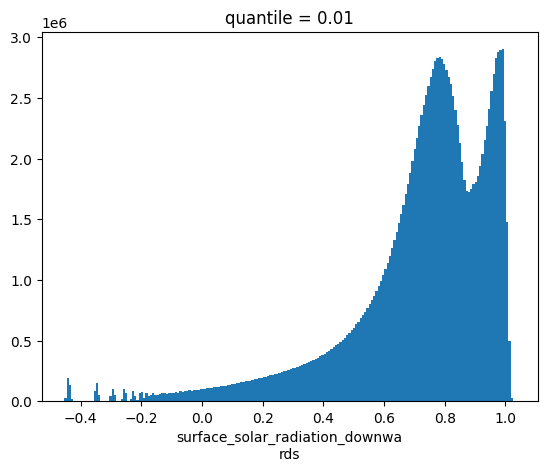

In [15]:
(
    normed_ds["surface_solar_radiation_downwards"].where(
        normed_ds["surface_solar_radiation_downwards"] >= -0.5
    )
).plot.hist(bins=200)
None

In [16]:
mixed_shift = xr.zeros_like(min_ds)
mixed_shift

<xarray.Dataset> Size: 16B
Dimensions:                            ()
Data variables:
    10m_u_component_of_wind            float32 4B 0.0
    10m_v_component_of_wind            float32 4B 0.0
    2m_temperature                     float32 4B 0.0
    surface_solar_radiation_downwards  float32 4B 0.0

In [17]:
mixed_shift["10m_u_component_of_wind"] = quantiles.sel(quantile=0.01)[
    "10m_u_component_of_wind"
]
mixed_shift["10m_v_component_of_wind"] = quantiles.sel(quantile=0.01)[
    "10m_v_component_of_wind"
]
mixed_shift["2m_temperature"] = quantiles.sel(quantile=0.01)["2m_temperature"]
mixed_shift["surface_solar_radiation_downwards"] = min_ds[
    "surface_solar_radiation_downwards"
]
mixed_shift

<xarray.Dataset> Size: 24B
Dimensions:                            ()
Coordinates:
    quantile                           float64 8B 0.01
Data variables:
    10m_u_component_of_wind            float32 4B -8.978
    10m_v_component_of_wind            float32 4B -8.963
    2m_temperature                     float32 4B 263.9
    surface_solar_radiation_downwards  float32 4B 0.0

In [18]:
mixed_shift = mixed_shift.drop_vars("quantile", errors="ignore")
mixed_shift

<xarray.Dataset> Size: 16B
Dimensions:                            ()
Data variables:
    10m_u_component_of_wind            float32 4B -8.978
    10m_v_component_of_wind            float32 4B -8.963
    2m_temperature                     float32 4B 263.9
    surface_solar_radiation_downwards  float32 4B 0.0

In [19]:
mixed_scale = xr.zeros_like(min_ds)
mixed_scale

<xarray.Dataset> Size: 16B
Dimensions:                            ()
Data variables:
    10m_u_component_of_wind            float32 4B 0.0
    10m_v_component_of_wind            float32 4B 0.0
    2m_temperature                     float32 4B 0.0
    surface_solar_radiation_downwards  float32 4B 0.0

In [20]:
mixed_scale["10m_u_component_of_wind"] = (
    quantiles.sel(quantile=0.99)["10m_u_component_of_wind"]
    - quantiles.sel(quantile=0.01)["10m_u_component_of_wind"]
)
mixed_scale["10m_v_component_of_wind"] = (
    quantiles.sel(quantile=0.99)["10m_v_component_of_wind"]
    - quantiles.sel(quantile=0.01)["10m_v_component_of_wind"]
)
mixed_scale["2m_temperature"] = (
    quantiles.sel(quantile=0.99)["2m_temperature"]
    - quantiles.sel(quantile=0.01)["2m_temperature"]
)
mixed_scale["surface_solar_radiation_downwards"] = (
    max_ds["surface_solar_radiation_downwards"]
    - min_ds["surface_solar_radiation_downwards"]
)
mixed_scale

<xarray.Dataset> Size: 16B
Dimensions:                            ()
Data variables:
    10m_u_component_of_wind            float32 4B 20.42
    10m_v_component_of_wind            float32 4B 18.72
    2m_temperature                     float32 4B 36.63
    surface_solar_radiation_downwards  float32 4B 6.583

In [21]:
mixed_scale = mixed_scale.drop_vars("quantile", errors="ignore")
mixed_scale

<xarray.Dataset> Size: 16B
Dimensions:                            ()
Data variables:
    10m_u_component_of_wind            float32 4B 20.42
    10m_v_component_of_wind            float32 4B 18.72
    2m_temperature                     float32 4B 36.63
    surface_solar_radiation_downwards  float32 4B 6.583